In [1]:
from utils import AverageMeter, load_inputs, get_png_names, get_ys, get_census
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, utils, models
from model import RecurrentAttention
import torch.nn.functional as F
from config import get_config
from trainer import Trainer
from PIL import Image
from tqdm import tqdm
import pandas as pd
import torchvision
import random
import shutil
import pickle
import torch
import utils
import json
import time

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [19]:
m = open("../../pooling/data/migration_data.json",)
mig_data = json.load(m)
m.close()

c = open("../../archive/CAOE/data/census_data.json",)
census = json.load(c)
c.close()  

In [20]:
mig_data = pd.DataFrame.from_dict(mig_data, orient = 'index').reset_index()
mig_data.columns = ['muni_id', 'num_migrants']
q = 4
mig_data['class'] = pd.qcut(mig_data['num_migrants'], q = q, labels = [i for i in range(q)])
mig_data.head()

,muni_id,num_migrants,class
0,484001001,42055.0,3
1,484001002,4017.0,3
2,484001003,11992.0,3
3,484001004,762.0,2
4,484001005,7551.0,3


In [21]:
image_names = get_png_names("../../attn/data/MEX/")
y_class, y_mig = get_ys(image_names, mig_data)
census_data = get_census(image_names, census)

In [22]:
train_num = int(25 * .70)
train_indices = random.sample(range(0, 25), train_num)
val_indices = [i for i in range(0, 25) if i not in train_indices]

In [23]:
batch_size = 1
train = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), y_class[i], y_mig[i], torch.tensor(census_data[i])) for i in train_indices]
val = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), y_class[i], y_mig[i], torch.tensor(census_data[i])) for i in val_indices]
train_dl = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_dl = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

In [24]:
print("Num training: ", len(train_dl))
print("Num validation: ", len(val_dl))

Num training:  17
Num validation:  8


In [25]:
import numpy as np
from utils import plot_images

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [26]:
config, unparsed = get_config()

In [27]:
trainer = Trainer(config, (train_dl, val_dl))

In [48]:
checkpoint = torch.load("./ckpt/ram_4_50x50_0.75_model_best.pth.tar")
checkpoint = checkpoint["model_state"]

In [49]:
import matplotlib.pyplot as plt

In [50]:
trues, preds, classes = [], [], []

# for i,o,o2 in val_dl:

for im in image_names:
    
    muni_id = im.split("/")[5]
    
    i = load_inputs(im)
    o = torch.tensor(mig_data[mig_data["muni_id"] == im.split("/")[5]]['class'].values[0])
    o2 = torch.tensor(mig_data[mig_data["muni_id"] == im.split("/")[5]]['num_migrants'].values[0])
    cur_census = torch.tensor(census[muni_id])
    
    pred = trainer.predict(1, i, o, o2, cur_census, checkpoint).item()
    true = o2.item()
    
    trues.append(true)
    preds.append(pred)
    classes.append(o.item())
    
preds_df = pd.DataFrame()
preds_df['true'], preds_df['pred'], preds_df['class'] = trues, preds, classes
preds_df.head()

,true,pred,class
0,1446.0,741.402039,2
1,25.0,1434.538696,0
2,0.0,172.938095,0
3,1559.0,2133.662109,2
4,7551.0,7601.801758,3


Text(0, 0.5, 'True')

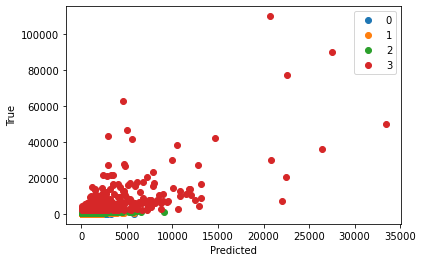

In [51]:
groups = preds_df.groupby("class")
for name, group in groups:
    plt.plot(group["pred"], group["true"], marker="o", linestyle="", label=name)
plt.legend()
plt.xlabel("Predicted")
plt.ylabel("True")

In [52]:
preds_df.to_csv("./imagery_census_preds_df_v4.csv")

Text(0, 0.5, 'True')

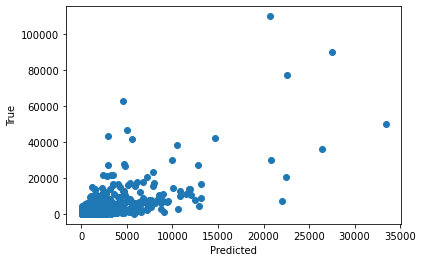

In [53]:
plt.scatter(preds_df['pred'], preds_df['true'])
plt.xlabel("Predicted")
plt.ylabel("True")

In [54]:
for name, group in groups:
    print(name, np.mean(abs(group["true"] - group["pred"])))

0 287.3699846415557
1 414.41567641731325
2 677.4557640525325
3 3868.4984039705855


In [55]:
preds_df

,true,pred,class
0,1446.0,741.402039,2
1,25.0,1434.538696,0
2,0.0,172.938095,0
3,1559.0,2133.662109,2
4,7551.0,7601.801758,3
...,...,...,...
2061,2487.0,3226.646484,3
2062,2024.0,1088.155640,3
2063,3084.0,947.591980,3
2064,2919.0,1878.654541,3


In [7]:
t1 = torch.rand(15)
t2 = torch.rand(20)

torch.cat((t1, t2), dim = 0)

tensor([0.4022, 0.6815, 0.4634, 0.3108, 0.5225, 0.7232, 0.8244, 0.0774, 0.4723,
        0.1403, 0.5124, 0.9170, 0.4406, 0.5869, 0.1935, 0.8079, 0.6587, 0.2768,
        0.0741, 0.6938, 0.9845, 0.9124, 0.6817, 0.9085, 0.4821, 0.1587, 0.8403,
        0.6928, 0.9084, 0.0583, 0.8985, 0.4787, 0.2940, 0.9754, 0.1638])

In [5]:
t1.flatten(start_dim = 0)

tensor([5.5405e-01, 1.8042e-01, 4.2831e-01, 7.1348e-02, 8.0335e-01, 9.6852e-01,
        6.4902e-01, 6.4082e-01, 7.7943e-01, 9.3032e-01, 6.0273e-01, 6.1298e-01,
        6.5617e-01, 1.7061e-01, 3.0664e-02, 6.1908e-01, 6.3068e-01, 6.8589e-01,
        7.2470e-01, 8.6956e-01, 5.0539e-01, 5.3187e-02, 6.0771e-01, 5.0363e-01,
        1.3508e-01, 1.6496e-01, 2.7752e-02, 8.3829e-01, 6.1804e-04, 4.1107e-01])